# Diseñador filtro LP ButterWorth

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.signal import butter, freqs


# Función para filtro Butterworth analógico (T(s), Bode)
def butterworth_analog(order, cutoff):
    # Obtener coeficientes del filtro analógico
    b, a = butter(order, cutoff, analog=True)
    
    # Crear la función de transferencia simbólica H(s)
    s = sp.Symbol('s')
    num = sum(b[i] * s**(len(b) - 1 - i) for i in range(len(b)))
    den = sum(a[i] * s**(len(a) - 1 - i) for i in range(len(a)))
    H_s = num / den

    # Mostrar la función de transferencia y el polinomio caracteristico
    display(sp.simplify(H_s))  # Muestra H(s) en Jupyter

    print("\nPolos del polinomio característico:")
    display(sp.roots(den))  # Muestra los polos del polinomio característico en Jupyter

    # Calcular la respuesta en frecuencia
    w, h = freqs(b, a)  # w en rad/s
    magnitude_db = 20 * np.log10(abs(h))  # Magnitud en dB
    magnitude_v = abs(h)  # Magnitud en Voltios

    # Crear figura
    fig, ax1 = plt.subplots(2, 1, figsize=(12, 8))

    # --- Gráfica de Bode - Magnitud ---
    ax1[0].semilogx(w, magnitude_db, label="Magnitud [dB]", color='b')
    ax1[0].set_ylabel("Magnitud [dB]", color='b')
    ax1[0].grid(which='both', linestyle='--', linewidth=0.7)
    ax1[0].set_title(f"Diagrama de Bode - Filtro Butterworth Orden {order}")

    # Segundo eje Y para la magnitud en Voltios
    ax2 = ax1[0].twinx()
    ax2.semilogx(w, magnitude_v, label="Magnitud [V]", color='r', linestyle="dashed")
    ax2.set_ylabel("Magnitud [V]", color='r')

    # --- Gráfica de Bode - Fase ---
    ax1[1].semilogx(w, np.angle(h, deg=True), label="Fase [°]", color='g')
    ax1[1].set_xlabel("Frecuencia [rad/s]")
    ax1[1].set_ylabel("Fase [°]")
    ax1[1].grid(which='both', linestyle='--', linewidth=0.7)

    # Mostrar gráfico
    plt.tight_layout()
    plt.show()


In [44]:
# Función para calcular los valores de Q para un filtro Butterworth según el orden


import numpy as np

def butterworth_Q_values(order):
    """Calcula los valores de Q para un filtro Butterworth de cualquier orden"""
    Q_values = []
    num_stages = order // 2  # Número de etapas de segundo orden
    for k in range(num_stages):
        Q_k = 1/((2*np.sin(np.pi/(2*order) + k*(np.pi/order))))
        Q_values.append(Q_k)
    return Q_values



In [36]:
# Ecuaciones necesarias para diseñar el circuito

r1 = sp.Symbol('R1')
r2 = sp.Symbol('R2')
c1 = sp.Symbol('C1')
c2 = sp.Symbol('C2')
q = sp.Symbol('Q')

wo = 1/sp.sqrt(c1*c2*r1*r2)

display(sp.Eq(wo, 2*np.pi*100))

eq_w_q = sp.Eq(2*np.pi*100/q, (1/(r2*c2) + 1/(r1*c2)))

display(eq_w_q)




Eq(1/sqrt(C1*C2*R1*R2), 628.318530717959)

Eq(628.318530717959/Q, 1/(C2*R2) + 1/(C2*R1))

In [37]:
# Función que resuelve los valores necesarios para el circuito

def solve_circuits(r1_val, c2_val, wo_val=2 * sp.pi * 100, q_val=1):
    # Definir símbolos
    r1, r2 = sp.symbols('R1 R2')
    c1, c2 = sp.symbols('C1 C2')
    
    # Definir ecuaciones
    wo = 1 / sp.sqrt(c1 * c2 * r1 * r2)
    eq_wo = sp.Eq(wo, wo_val)
    
    eq_w_q = sp.Eq(wo_val / q_val, (1 / (r2 * c2) + 1 / (r1 * c2)))
    
    # Resolver ecuaciones
    soluciones = sp.solve([eq_wo.subs({r1: r1_val, c2: c2_val}), eq_w_q.subs({r1: r1_val, c2: c2_val})], (c1, r2))
    
    return soluciones

# Ejemplo de uso con R1 = 100k y C2 = 1uF
solucion = solve_circuits(100e3, 1e-6)
solucion


[(1.56621913500837e-8, 1617.28939101801)]

In [38]:

# Genera las etapas de el circuito para el filtro indicado

def sallen_key_params(order, cutoff, r1_val=100e3, c2_val=1e-6):
    """ Calcula los valores de C1 y R2 para un filtro Sallen-Key basado en Butterworth.
        Si el orden es impar, añade una etapa de primer orden con ganancia unitaria.
    """
    # Frecuencia de corte en rad/s
    wc = 2 * np.pi * cutoff
    resistor_values = []

    # Obtener los factores de calidad Q automáticamente
    Q_values = butterworth_Q_values(order)
    print("Q Values: {}".format(Q_values))

    # Separar en etapas Sallen-Key y una etapa de primer orden si el orden es impar
    last_stage = (order % 2 == 1)  # True si el orden es impar

    # Calcular C1 y R2 para cada etapa Sallen-Key
    for Q in Q_values:
        solved_eq = solve_circuits(r1_val, c2_val, wc, Q)
        C1 = solved_eq[0][0]
        R2 = solved_eq[0][1]
        resistor_values.append(("Sallen-Key", C1, R2))

    # Si el orden es impar, añadir la etapa de primer orden con ganancia unitaria
    if last_stage:
        Ra = Rf = 1 / (wc * c2_val)  # Ra = Rf para ganancia = 1
        resistor_values.append(("Primer orden", Ra, Rf))

    return resistor_values

resistores = sallen_key_params(order=5, cutoff=10000)
for stage in resistores:
    print(stage)

Q Values: [0.6180339887498948, 1.618033988749895]
('Sallen-Key', 2.57492777104331e-10, 9.83728405722273)
('Sallen-Key', 9.83378340124359e-11, 25.7584440057741)
('Primer orden', 15.915494309189533, 15.915494309189533)


# Función principal

In [39]:
def filtro_butterworth(order, cutoff, r1, c2):
    butterworth_analog(order, cutoff)

    resistores = sallen_key_params(order, cutoff, r1, c2)
    for stage in resistores:
        if stage[0] == "Primer orden":
            print("Etapa: {}, Ra: {:.2f} Ohm, Rf: {:.2f} Ohm".format(stage[0], stage[1], stage[2]))
        else:
            print("Etapa: {}, C1: {:.2e} F, R2: {:.2f} Ohm".format(stage[0], stage[1], stage[2]))



# Ejemplos de Uso

1.0e+20/(1.0*s**5 + 32360.6797749979*s**4 + 523606797.749979*s**3 + 5236067977499.79*s**2 + 3.23606797749979e+16*s + 1.0e+20)


Polos del polinomio característico:


{-10000.0000000000: 1,
 -8090.16994374947 - 5877.85252292473*I: 1,
 -8090.16994374947 + 5877.85252292473*I: 1,
 -3090.16994374947 - 9510.56516295153*I: 1,
 -3090.16994374947 + 9510.56516295153*I: 1}

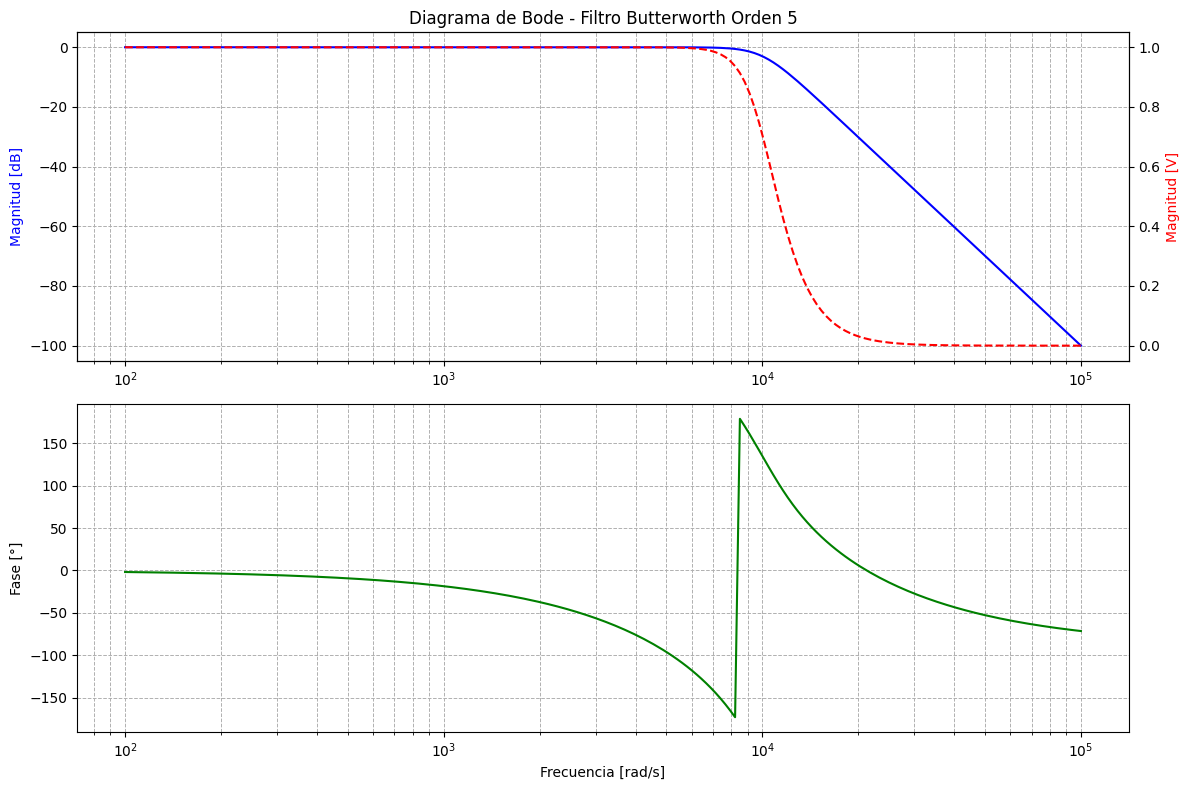

Q Values: [0.6180339887498948, 1.618033988749895]
Etapa: Sallen-Key, C1: 2.57e-10 F, R2: 9.84 Ohm
Etapa: Sallen-Key, C1: 9.83e-11 F, R2: 25.76 Ohm
Etapa: Primer orden, Ra: 15.92 Ohm, Rf: 15.92 Ohm


In [40]:
filtro_butterworth(order=5, cutoff=10000, r1=100e3, c2=1e-6)

1000000000.0/(1.0*s**3 + 2000.0*s**2 + 2000000.0*s + 1000000000.0)


Polos del polinomio característico:


{-1000.00000000000: 1,
 -500.0 - 866.025403784439*I: 1,
 -500.0 + 866.025403784439*I: 1}

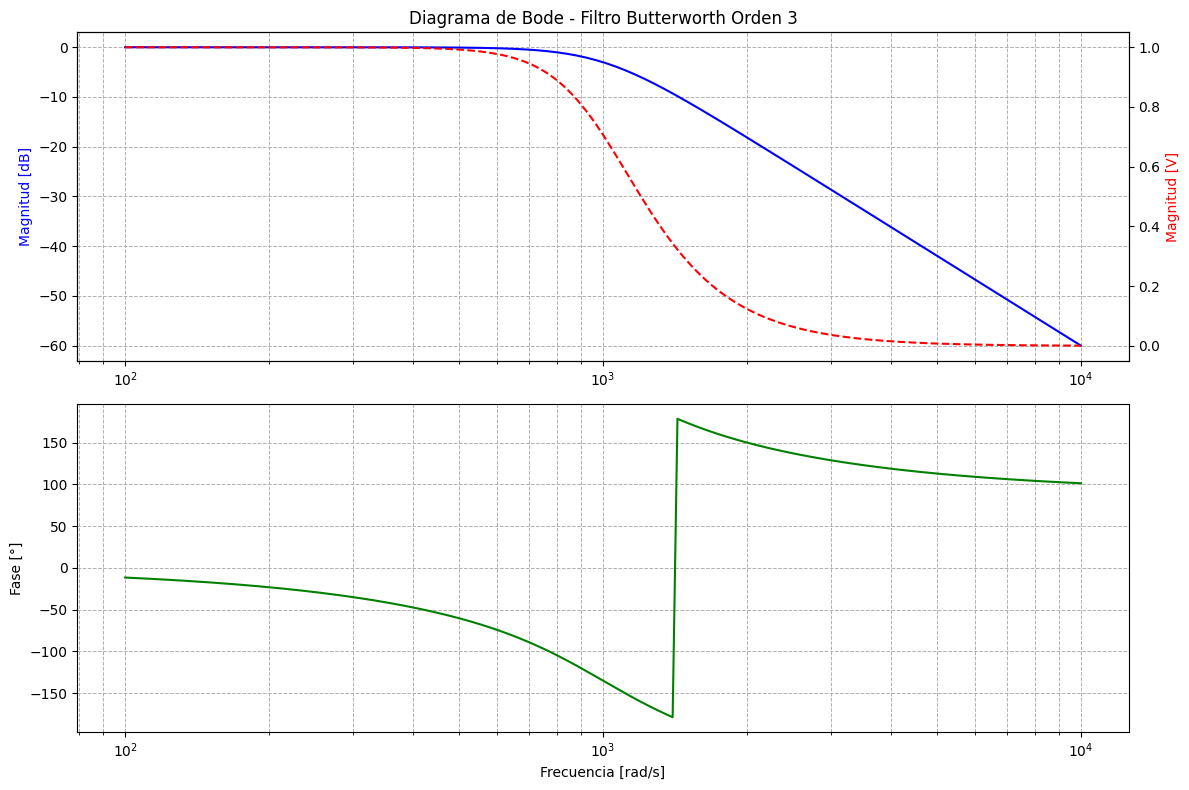

Q Values: [0.9999999999999999]
Etapa: Sallen-Key, C1: 1.59e-9 F, R2: 159.41 Ohm
Etapa: Primer orden, Ra: 159.15 Ohm, Rf: 159.15 Ohm


In [41]:
filtro_butterworth(order=3, cutoff=1000, r1=100e3, c2=1e-6)

4.22351360321045e+20/(1.0*s**11 + 527.00056374992*s**10 + 138864.797096367*s**9 + 24055425.224081*s**8 + 3035506718.02717*s**7 + 292462651000.064*s**6 + 21934698825004.8*s**5 + 1.28060439666771e+15*s**4 + 5.70846516548016e+16*s**3 + 1.85362128448336e+18*s**2 + 3.95696719981753e+19*s + 4.22351360321045e+20)


Polos del polinomio característico:


{-75.0000000001513: 1,
 -71.9619730209705 - 21.1299417630764*I: 1,
 -71.9619730209705 + 21.1299417630764*I: 1,
 -63.094014962396 - 40.5480613091928*I: 1,
 -63.094014962396 + 40.5480613091928*I: 1,
 -49.1145550458736 - 56.6812180765645*I: 1,
 -49.1145550458736 + 56.6812180765645*I: 1,
 -31.1561259751495 - 68.2223996515888*I: 1,
 -31.1561259751495 + 68.2223996515888*I: 1,
 -10.6736128704949 - 74.2366081410699*I: 1,
 -10.6736128704949 + 74.2366081410699*I: 1}

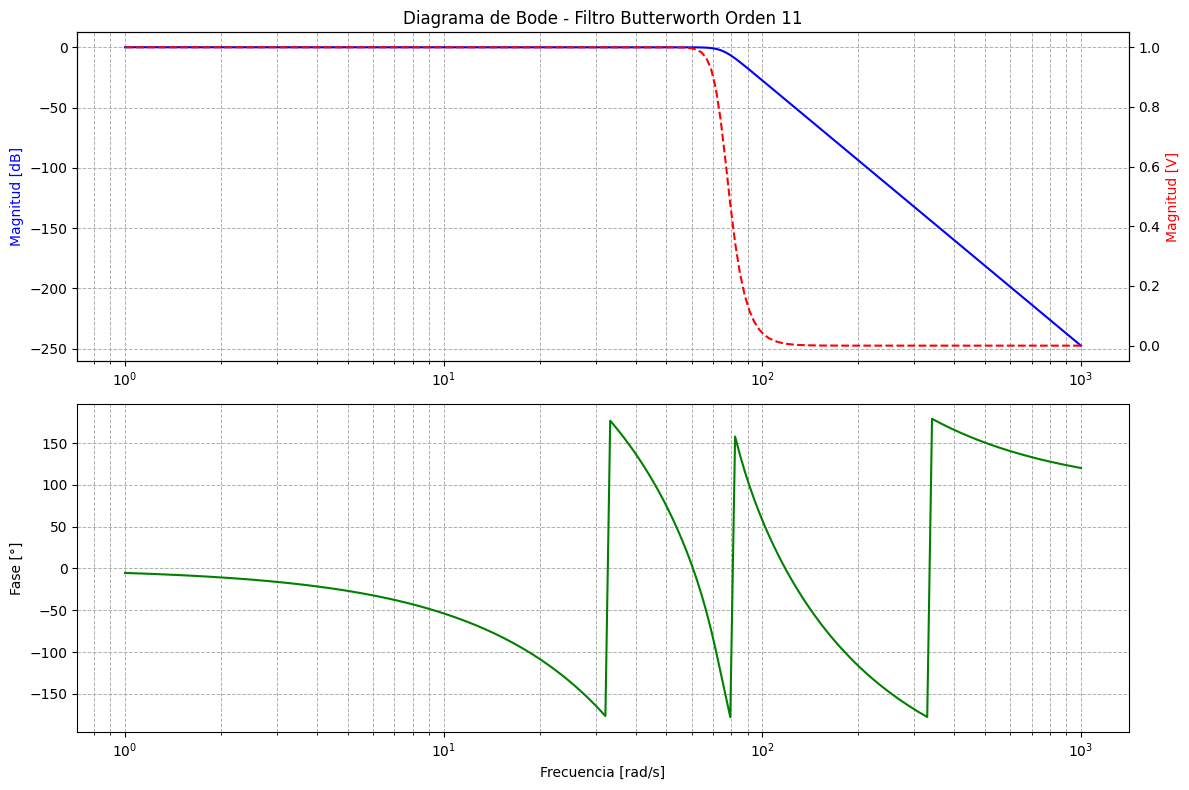

Q Values: [0.2846296765465703, 0.8308300260037728, 1.3097214678905702, 1.6825070656623622, 1.9189859472289947]
Etapa: Sallen-Key, C1: 7.45e-8 F, R2: 60.44 Ohm
Etapa: Sallen-Key, C1: 2.55e-8 F, R2: 176.62 Ohm
Etapa: Sallen-Key, C1: 1.62e-8 F, R2: 278.71 Ohm
Etapa: Sallen-Key, C1: 1.26e-8 F, R2: 358.32 Ohm
Etapa: Sallen-Key, C1: 1.10e-8 F, R2: 408.89 Ohm
Etapa: Primer orden, Ra: 212.21 Ohm, Rf: 212.21 Ohm


In [42]:
filtro_butterworth(order=11, cutoff=75, r1=100e3, c2=10e-6)

# Filtro a diseñar, 50Hz pasabajas (2 Ejemplos)

125000.0/(1.0*s**3 + 100.0*s**2 + 5000.0*s + 125000.0)


Polos del polinomio característico:


{-50.0000000000000: 1,
 -25.0 - 43.3012701892219*I: 1,
 -25.0 + 43.3012701892219*I: 1}

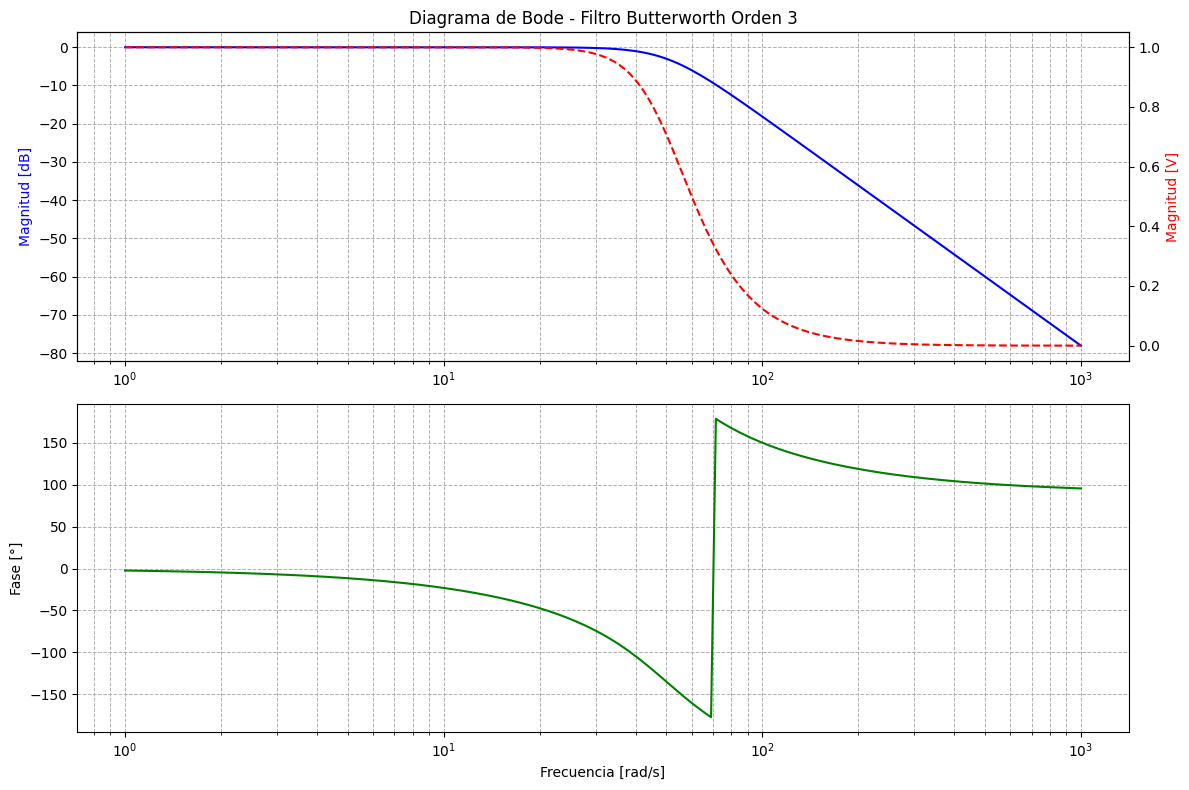

Q Values: [1.0000000000000002]
Etapa: Sallen-Key, C1: 3.08e-8 F, R2: 3287.75 Ohm
Etapa: Primer orden, Ra: 3183.10 Ohm, Rf: 3183.10 Ohm


In [54]:
filtro_butterworth(order=3, cutoff=50, r1=100e3, c2=1e-6)


312500000.0/(1.0*s**5 + 161.803398874989*s**4 + 13090.1699437495*s**3 + 654508.497187474*s**2 + 20225424.8593737*s + 312500000.0)


Polos del polinomio característico:


{-50.0000000000000: 1,
 -40.4508497187474 - 29.3892626146236*I: 1,
 -40.4508497187474 + 29.3892626146236*I: 1,
 -15.4508497187473 - 47.5528258147577*I: 1,
 -15.4508497187473 + 47.5528258147577*I: 1}

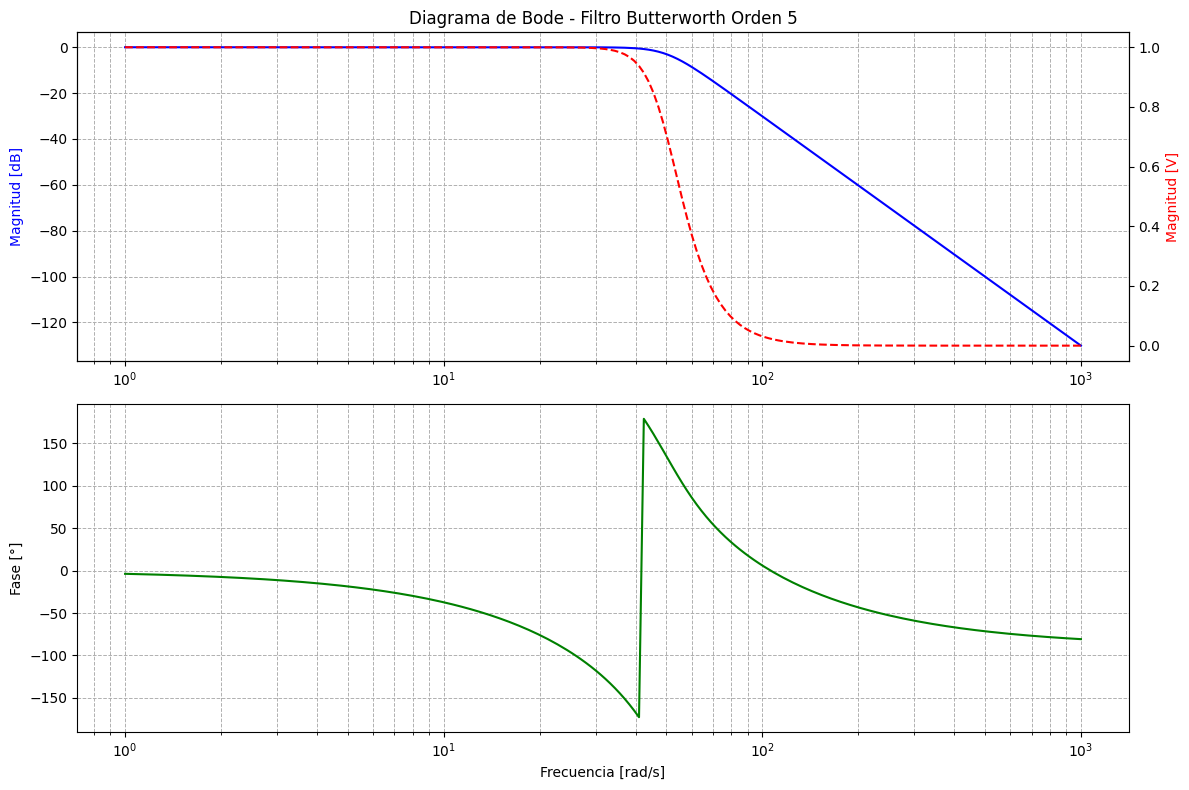

Q Values: [1.618033988749895, 0.6180339887498948]
Etapa: Sallen-Key, C1: 1.87e-8 F, R2: 5430.03 Ohm
Etapa: Sallen-Key, C1: 5.05e-8 F, R2: 2006.74 Ohm
Etapa: Primer orden, Ra: 3183.10 Ohm, Rf: 3183.10 Ohm


In [53]:
filtro_butterworth(order=5, cutoff=50, r1=100e3, c2=1e-6)